<a href="https://colab.research.google.com/github/okchang95/aiffel_quest_changwoo/blob/main/DeepLearningWithPython/chapter08_intro_to_dl_for_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 08. 컴퓨터비전을 위한 딥러닝
---
8.1 합성곱 신경망 소개<br>
8.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기<br>
8.3 사전 훈련된 모델 활용하기<br>
8.4 요약


- convnet 이해
- augmentation
- pretrained convnet for feature extract
- pretrained model fine tuning

## 8.1 합성곱 신경망 소개

MNIST에 convnet 사용 예시

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# 기본적인 convnet 모습 (batch차원을 제외하고 h, w, c 크기의 입력을 사용)

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPool2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

In [ ]:
from tensorflow.keras.datasets import mnist

In [ ]:
# 훈련

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape ((10000, 28, 28, 1))
test_images =test_images.astype("float32") / 255

model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
938/938 [==============================] - 7s 4ms/step - loss: 0.1678 - accuracy: 0.9477
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0455 - accuracy: 0.9862
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0313 - accuracy: 0.9902
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0231 - accuracy: 0.9927
Epoch 5/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0181 - accuracy: 0.9945


In [ ]:
# 평가
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트정확도: {test_acc: .3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0308 - accuracy: 0.9917
테스트정확도:  0.992


97.8 test_acc -> 99,1 test_acc

### 8.1.1 합성곱 연산

- desne -> input feature space에 있는 전역 패턴을 학습
- conv -> 지역 패턴을 학습

장점 :
1. 학습된 패턴은 평행 이동 불변성(translation invariant)을 가집니다
2. 컨브넷은 패턴의 공간적 계층 구조를 학습할 수 있습니다.

output size 계산 :

`output size` = (`input size` - `filter size` + 2 * `padding`) / `stride` + 1

-  이 결과 행렬이 정수가 되도록 padding, filter값을 조정하는 것이 관습적(정수 아닐땐 내림)

### 8.1.2 최대 풀링 연산(MaxPooling)

 : feature map을 downsampling하는 역할
-  입력 특성 맵에서 윈도우에 맞는 패치를 추출하고 각 채널별로 최댓값을 출력

- conv와의 차이점 :
    - 합성곱 연산을 사용하는게 아닌 하드코딩된 최댓값 추출 연산을 사용.
    - maxpool : 보통 kernel_size=2x2, stride=2를 사용 (절반크기로 downsampling)
    - convnet : 보통 kernel_size=3x3, stride=1을 사용

- maxpooling 하지 않을 때 : 두가지 문제
    1. 초기 입력에 관한 정보가 적어 특성의 공간적 계층 구조를 학습하는데 도움이 되지 않음
    2. 강제적으로 downsampling을 하지 않으면 가중치가 너무 많아져 심각한 overfitting 발생

- downsampling 이유 : feature map의 weights를 줄이기 위함 (avepool도 사용 가능)

- pool size = 2 :
    - filter = 2,
    - stride = 2
    - 겹치지 않고 1/2로 줄여줌



## 8.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기
---
- dataset : 5000 개의 cat,dog image
- task : binary classification
- split : train-2000 / val-1000 / test-2000
- 기준 모델 : no regularization.
    - 이 방법은 약`70%`의 분류 정확도를 달성할 것입니다.
    - 이 방법의 주요 이슈는 과대적합이 될 것입니다.


그 다음 컴퓨터 비전에서 과대적합을 줄이기위한 강력한 방법인 데이터증식(data augmenation)을 소개 하겠습니다.

데이터 증식을 통해 네트워크의 성능을 `80~85%` 정확도로 향상시킬 것입니다.

- 작은 데이터셋에 딥러닝을 적용하기 위한 핵심적인 기술 두가지
    1. pretrained network로 feature extract (97.5% acc)
    2. pretrained network를 fine tuning (98.5% acc)



### 8.2.1 작은 데이터셋 문제에서 딥러닝의 타당성

- '충분한 샘플' -> 모델의 크기와 깊이에 상대적
- 보통 수십개의 샘플만 사용해서 conv를 훈련하는 건 불가능.
- 하지만 모델이 작고 규제가 잘 되어있으며 간단한 작업이라면 "수백개의 샘플"로도 충분할 수 있음

- convnet 특징중 하나 : 지역적이고 평행 이동으로 변하지 않는 특성 학습으로 "지각" 문제에서 매우 효율적으로 데이터 사용 -> 작은 이미지 데이터셋에서 feature engineering 없이 납득할 만한 결과 가능

- 딥러닝 큰 장점 중 하나 : feature reuse



### Data download

Dogs vs Cat dataset : 케라스에 없고 캐글에서 다운 가능.

* 코랩에서 캐글 데이터셋 다운로드 :

In [ ]:
#!kaggle competitions download -c dogs-vs-cats

# 사용자 인증
'''
1. 캐글 account에서 token 다운로드 - kaggle.json
2. api key가 담긴 json file 현재 코랩 세션에 업로드
'''
from google.colab import files
files.upload()
'''
3. ~/.kaggle 폴더를 만들고 키 파일을 이 폴더로 복사,
   보안을 위해 사용자만 이 파일을 읽을 수 있게 설정
4. 캐글에서 데이터 규칙에 동의 : https://www.kaggle.com/c/dogs-vs-cats/rules
5. data download
6. 압축 해제
'''


Saving kaggle.json to kaggle.json


'\n3. ~/.kaggle 폴더를 만들고 키 파일을 이 폴더로 복사, \n   보안을 위해 사용자만 이 파일을 읽을 수 있게 설정\n4. 캐글에서 데이터 규칙에 동의 : https://www.kaggle.com/c/dogs-vs-cats/rules\n5. data download\n6. 압축 해제\n'

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

 99% 802M/812M [00:03<00:00, 244MB/s]
100% 812M/812M [00:03<00:00, 240MB/s]


- 이 데이터셋은 25000개의 강아지와 고양이 이미지,
- 클래스마다 12500개
- 압축해서 543MB

<br>

- 3개의 subset이 들어있는 새로운 데이터 셋 작성
- train : 클래스마다 1000개의 sample
- val : 클래스마다 500개의 sample
- test : 클래스마다 1000개의 sample

<br>

- 데이터셋을 줄이는 이유 : 많은 데이터가 있으면 문제가 더 쉬워줘서 배울 땐 작은 데이터셋이 좋음.

<br>

- shutil package로 디렉터리 만들기

In [ ]:
# 이미지를 디렉터리로 복사
import os, shutil, pathlib

# 원본 데이터셋 경로
original_dir = pathlib.Path("train")
# subset 데이터 저장 경로
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        # cats_vs_dogs_small / train / cat / -> 이렇게 생긴 디렉터리 생성
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname, dst=dir / fname)

# 카테고리마다 처음 1000개 train, 500 val, 1000 test subset
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


### build model

input (180, 180) -> (7, 7) feature map -> flatten

binary classification -> dense(1, sigmoid)

- Q. layer.Rescaling? -> "scailing"

`x = layers.Rescaling(1./255)(inputs)`
-> 입력을 255로 나누어 [0, 1]범위로 스케일 조정

> input image ->
- augmentation
- rescaling
- (conv2d, maxpooling) x n
- flatten
- dropout
- output dense(pred 뽑아냄) -> output scalar

In [ ]:
# 소규모 convnet 작성
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs) # 입력을 255로 나누어 [0, 1] 범위로 scaling
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

In [ ]:
# 모델 훈련 설정
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### data preprocessing

 : network에 집어넣기 전에 floatType tensor로 바꿔줘야함.

 - JPEG -> tensor
1. read image
2. decoding JPEG to RGB pixel value
3. go float tensor
4. size -> 180, 180
5. batch(=32)

keras는 위 단계를 자동으로 처리하는 유틸리티 있음!! :
`image_dataset_from_directory(directory)`

- 디스크에 있는 이미지 파일을 자동으로 전처리된 텐서의 배치로 변환하는 데이터 파이프라인을 빠르게 구성.
    - 호출하면
    1. directory의 sub-directory를 찾음
    2. 각 subdir에는 한 클래스에 해당하는 이미지가 담겨있다고 가정
    3. 각 sub-dir에 있는 이미지 파일 indexing
    4. 이런 파일을 읽고, 순서를 섞고, 텐서로 디코딩, 동일 크기로 변경, 배치로 묶어주는 >>
    - tf.data.Dataset객체를 만들어 반환

In [ ]:
# 이미지 읽기
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
# Dataset 확인
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


In [ ]:
# training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 12s 102ms/step - loss: 0.7074 - accuracy: 0.5165 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 5s 71ms/step - loss: 0.6916 - accuracy: 0.5380 - val_loss: 0.6811 - val_accuracy: 0.5700
Epoch 3/30
63/63 [==============================] - 4s 57ms/step - loss: 0.6807 - accuracy: 0.5840 - val_loss: 0.6608 - val_accuracy: 0.6640
Epoch 4/30
63/63 [==============================] - 5s 84ms/step - loss: 0.6497 - accuracy: 0.6250 - val_loss: 0.6237 - val_accuracy: 0.6810
Epoch 5/30
63/63 [==============================] - 6s 97ms/step - loss: 0.6135 - accuracy: 0.6585 - val_loss: 0.6526 - val_accuracy: 0.6010
Epoch 6/30
63/63 [==============================] - 6s 94ms/step - loss: 0.5767 - accuracy: 0.6895 - val_loss: 0.6066 - val_accuracy: 0.6710
Epoch 7/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5454 - accuracy: 0.7240 - val_loss: 0.5914 - val_accuracy: 0.6760
Epoch 8/30
63/63 [==============================] - 4s 58ms/step - loss: 0.5153 - accuracy: 0.7425 - val_loss: 0.5637 - val_accuracy: 0.7120
Epoch 9/30
63/63 [======

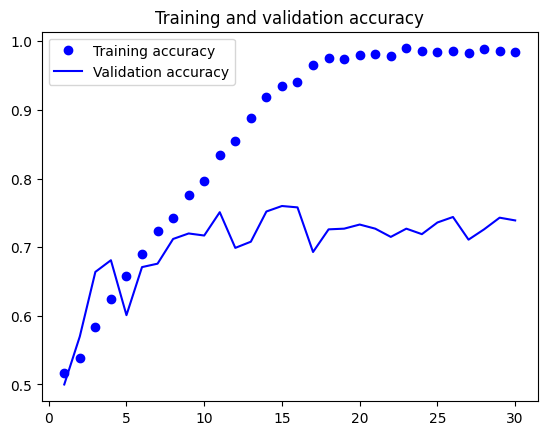

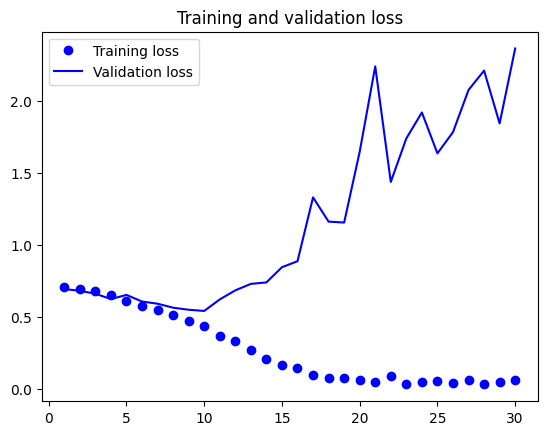

In [ ]:
# 훈련 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# 테스트 세트에서 모델 평가하기

test_model = keras.models.load_model("convnet_from_scratch.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 30ms/step - loss: 0.5540 - accuracy: 0.7355
테스트 정확도: 0.735


### 8.2.5 augmentation

그럴듯한 이미지를 생성하도록 여러가지 랜덤한 변환을 적용하여 샘플을 늘립니다.

훈련할 때 모델이 정확히 같은 데이터를 두 번 만나지 않도록 하는 것이 목표

In [ ]:
# 컨브넷에 추가할 데이터 증식 단계 정의하기

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

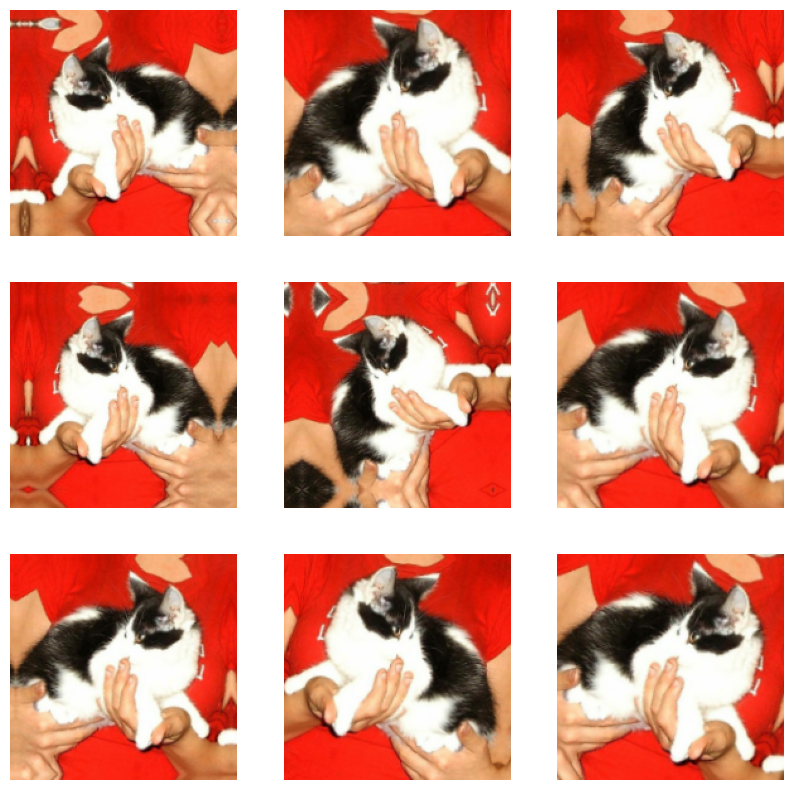

In [ ]:
# augmentated image 확인

plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

새로운 정보가 아니라 기존 정보의 재조합 뿐이라 overfitting을 더 막기 위해 `dropout`추가

random augmentation layer는 dropout처럼
predict(), evaluate() 메서드를 호출할 때 동작하지 않음.

In [ ]:
# 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 8s 85ms/step - loss: 0.6958 - accuracy: 0.5120 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 4s 57ms/step - loss: 0.6935 - accuracy: 0.5355 - val_loss: 0.6819 - val_accuracy: 0.6200
Epoch 3/100
63/63 [==============================] - 4s 57ms/step - loss: 0.6832 - accuracy: 0.5630 - val_loss: 0.6741 - val_accuracy: 0.5840
Epoch 4/100
63/63 [==============================] - 5s 75ms/step - loss: 0.6700 - accuracy: 0.6070 - val_loss: 0.6622 - val_accuracy: 0.6200
Epoch 5/100
63/63 [==============================] - 4s 57ms/step - loss: 0.6734 - accuracy: 0.6165 - val_loss: 0.6464 - val_accuracy: 0.5820
Epoch 6/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6217 - accuracy: 0.6600 - val_loss: 0.7033 - val_accuracy: 0.5500
Epoch 7/100
63/63 [==============================] - 4s 59ms/step - loss: 0.6220 - accuracy: 0.6525 - val_loss: 0.6393 - val_accuracy: 0.6120
Epoch 

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 2s 29ms/step - loss: 0.4751 - accuracy: 0.8620
테스트 정확도: 0.862


## 8.3 사전 훈련된 모델 활용하기

사전 훈련된 모델(pretrained model)은 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련된 모델

원본 데이터셋이 충분히 크고 일반적이라면 사전훈련된 모델에 의해 학습된 특성의 계층구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다.

새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터비전 문제에 유용

- 사용할 모델 : ImageNet dataset에서 훈련된 대규모 컨브넷 사용
- ImageNet dataset : 14,000,000 labeled images, 1000개 classes
- VGG16 구조 사용.


- pretrained model 사용 두 가지 방법
1. feature extraction
2. fine tuning


### feature extraction (VGG16)

convnet = conv base + classifier

여기서 conv base만 사용. conv layer에 의해 학습된 표현이 더 일반적이어서 재사용 가능.

classifier는 훈련된 클래스 집합에 특화되어 있음. 전체 사진에 어던 클래스가 존재할 확률에 관한 정보만 담고 있음.




In [ ]:
# VGG16 합성곱 기반 층 만들기
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",         # 모델을 초기화할 가중치 체크포인트를 지정
    include_top=False,          # 네트워크 맨 위에 놓인 dense classifer 포함여부 지정
    input_shape=(180, 180, 3))  # 네트워크에 주입할 텐서 크기. 선택사항. 지정하지 않음 어떤 값도 다 처리.

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

최종 feature map size : 5, 5, 512

여기에 dense layer 둘 건데, 여기서 두가지 방법 가능
1. 새로운 데이터셋에서 합성곱 기반 층 실행, 출력을 numpy array로 디스크에 저장. 이 데이터를 독립된 밀집 연결 분류기에 입력으로 사용. (conv 비용이 비싸기 때문. but augmentation 사용 불가)
2. 준비한 모델 위에 dense 층을 쌓아 확장. end-to-end로 전체 모델 실행. augmentation 가능, 비용이 큼


#### (1) no augmentation

: conv_base model의 predict()호출, numpy array로 feature map 추출.

- 중요한점 : predict() method가 label은 제외하고 이미지만 기대.
- 하지만 현재 데이터셋은 이미지와 레이블을 함께 담고 있는 배치를 반환
- 또한, VGG16 모델은 적적한 범위로 픽셀 값을 조정해주는
<br>`keras.applications.vgg16.preprocess_input` 함수로 전처리된 입력을 기대.

추출된 feature의 크기는 (sample, 5, 5, 512)

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # VGG16 input에 맞는 preprocessing
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        # training
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    # 따로 처리된 feature와 label을 tuple로 반환,, ?
    return np.concatenate(all_features), np.concatenate(all_labels)

# 각 ndarray로 변환된 feature, label값 저장
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 20ms/step


In [ ]:
# feature size 확인
train_features.shape

(2000, 5, 5, 512)

In [ ]:
# dense classifier 정의, 방금 저장한 데이터와 레이블에서 훈련.
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.h5",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 1s 9ms/step - loss: 19.0452 - accuracy: 0.9185 - val_loss: 3.1496 - val_accuracy: 0.9660
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 4.1949 - accuracy: 0.9750 - val_loss: 3.0521 - val_accuracy: 0.9750
Epoch 3/20
63/63 [==============================] - 0s 5ms/step - loss: 2.2755 - accuracy: 0.9815 - val_loss: 4.7775 - val_accuracy: 0.9680
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 0.6546 - accuracy: 0.9935 - val_loss: 4.2567 - val_accuracy: 0.9700
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1842 - accuracy: 0.9895 - val_loss: 6.6710 - val_accuracy: 0.9690
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.7775 - accuracy: 0.9950 - val_loss: 4.3099 - val_accuracy: 0.9730
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.2625 - accuracy: 0.9980 - val_loss: 3.7824 - val_accuracy: 0.9730
Epoch 8/20
63/63 [=

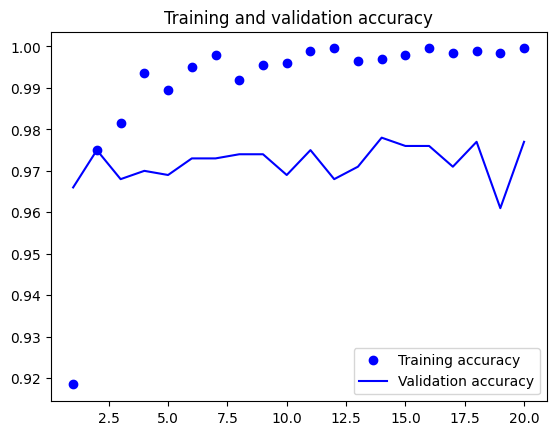

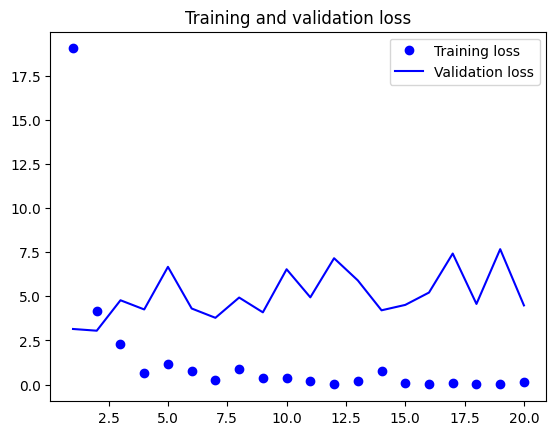

In [ ]:
# 시각화
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

-> 시작하자마자 overfitting : 사전 훈련된 모델이 현재 작업에 딱맞는 지식을 이미 가지고 있어서

많은 비율의 드랍아웃에서도 ... -> augmentation(작은 이미지 데이터셋에 필수적)

#### (2) end-to-end : use augmentation

먼저 conv_base를 "freezing"시켜야함. -> 훈련동안 가중치가 업데이트되지 않도록 막는 다는 뜻

이렇게 안하면 사전학습된 표현이 훈련동안 수정되버림.

맨위의 dense층이 랜덤하게 초기화되는거라서 가중치업데이트 이상하게 전파됨 -> 훼손

- keras에서는 `trainable = False`로 설정

In [ ]:
# VGG16 합성곱 기반 층을 만들고 동결하기

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = False


In [ ]:
# 동결하기 전과 후에 훈련 가능한 가중치 리스트를 출력하기

conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 26
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


data augmentation + freezed conv_base layer + dense classifier

In [ ]:
# model concat

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

# 변경사항 저장
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

이렇게 설정하면 dense 2개만 훈련됨.

층마다 2개씩 (W, b) 총 4개의 tensor가 훈련.

변경사항을 적용하려면 먼저 모델을 컴파일.

컴파일 단계 후 trainable 속성을 변경하면 반드시 모델을 다시 컴파일. 안하면 적용 안됨.

학습 ㄱㄱ

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 13s 179ms/step - loss: 17.6901 - accuracy: 0.9075 - val_loss: 11.9838 - val_accuracy: 0.9390
Epoch 2/50
63/63 [==============================] - 9s 145ms/step - loss: 6.8502 - accuracy: 0.9450 - val_loss: 6.0275 - val_accuracy: 0.9680
Epoch 3/50
63/63 [==============================] - 10s 148ms/step - loss: 6.4399 - accuracy: 0.9555 - val_loss: 5.7155 - val_accuracy: 0.9640
Epoch 4/50
63/63 [==============================] - 10s 150ms/step - loss: 5.4003 - accuracy: 0.9590 - val_loss: 4.2019 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 12s 184ms/step - loss: 4.2462 - accuracy: 0.9645 - val_loss: 3.8719 - val_accuracy: 0.9730
Epoch 6/50
63/63 [==============================] - 10s 154ms/step - loss: 4.8512 - accuracy: 0.9600 - val_loss: 6.3544 - val_accuracy: 0.9720
Epoch 7/50
63/63 [==============================] - 10s 148ms/step - loss: 4.3519 - accuracy: 0.9680 - val_loss: 5.4133 - val_accuracy: 0.972

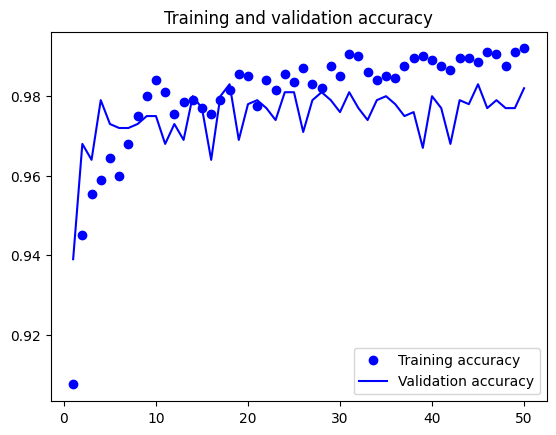

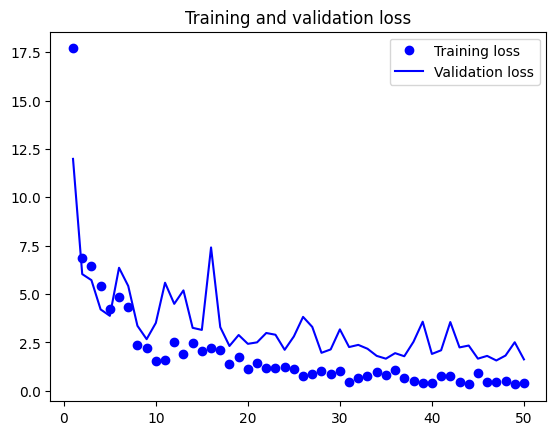

In [ ]:
# 시각화

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
# 평가
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 6s 93ms/step - loss: 2.2724 - accuracy: 0.9760
테스트 정확도: 0.976


### fine tuning

 : freezed model의 "상위 층" 몇 개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것.
- 상위층 : 가장 이후에 있는..층..

주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 `fine tuning`이라고 부름

#### 순서:
1. 사전 훈련된 기반 네트워크 위에 새로운 네트웤 추가
2. 기반 네트워크 동결
3. 새로 추가한 네트워크 훈련
4. 기반 네트워크에서 일부 층을 동결ㄹ 해제
    - batch normalization층은 해제하면 안됨
5. 동결 해제한 층과 새로 추가한 층을 함께 훈련.

1 ~ 3 은 이미 진행.  
4부터 진행

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

마지막 3개의 합성곱 층 fine tuning.

-> block4_pool 까지 모든 층은 동결. 뒤붙터 학습대상.

더 많은 층을 미세조정하지 않는 이유 :

- conv base 의 하위 층(초반 층)들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩.
- 반면 상위 층(후반 층)은 좀 더 특화된 특성을 인코딩.
- 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성, 이들을 조정하는게 유리.

- 훈련할 파라미커가 많을수록 overfitting 커짐

- learning rate 낮추는 이유 : 3개의 층에서 학습됨 표현 수정을 조금씩만 하기 위해서 -> 변경량이 너무 크면 학습된 표현에 나쁜 영향을 줄 수 있음.

In [ ]:
# 마지막 네번째 층 까지 모등 층 동결

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False


In [ ]:
# FINE TUNING

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 13s 167ms/step - loss: 0.5171 - accuracy: 0.9910 - val_loss: 1.3185 - val_accuracy: 0.9840
Epoch 2/30
63/63 [==============================] - 10s 162ms/step - loss: 0.5227 - accuracy: 0.9895 - val_loss: 1.6963 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - 11s 165ms/step - loss: 0.3477 - accuracy: 0.9910 - val_loss: 1.6121 - val_accuracy: 0.9830
Epoch 4/30
63/63 [==============================] - 11s 168ms/step - loss: 0.3595 - accuracy: 0.9905 - val_loss: 1.7183 - val_accuracy: 0.9780
Epoch 5/30
63/63 [==============================] - 11s 166ms/step - loss: 0.4223 - accuracy: 0.9925 - val_loss: 1.8393 - val_accuracy: 0.9780
Epoch 6/30
63/63 [==============================] - 12s 195ms/step - loss: 0.3510 - accuracy: 0.9920 - val_loss: 2.8346 - val_accuracy: 0.9750
Epoch 7/30
63/63 [==============================] - 11s 164ms/step - loss: 0.4193 - accuracy: 0.9915 - val_loss: 1.8758 - val_accuracy: 0.9800

In [ ]:
# 평가
model = keras.models.load_model("fine_tuning.h5")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

63/63 [==============================] - 6s 92ms/step - loss: 2.4309 - accuracy: 0.9785
테스트 정확도: 0.979
